In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import nltk
import re
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator,STOPWORDS
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import TextBlob
from nltk.collocations import *
from PIL import Image

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('gazetteers')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package gazetteers to /root/nltk_data...
[nltk_data]   Unzipping corpora/gazetteers.zip.


True

Mounting the Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = '/content/drive/My Drive/Internship CS778/reddit'

In [ ]:
#change directory to the DataViz Folder
import os
os.chdir(PATH)

In [ ]:
#check if the data-set is inside that directory
!ls

au_topic.csv		       COVID_AU_national.csv	  reddit_uk_label2.csv
au_topic_time.csv	       lda_tuning_results.csv	  reddit_uk_label.csv
Comments_AUtop500.csv	       lda_tuning_results.gsheet  reddit_us_label2.csv
Comments_CAtop500.csv	       reddit_au_label2.csv	  reddit_us_label.csv
Comments_Coronavirustop20.csv  reddit_au_label.csv	  test_dataset.json
Comments_globaltop50.csv       reddit_ca_label2.csv	  topic_case.csv
Comments_UKtop500.csv	       reddit_ca_label.csv	  train_dataset.json
Comments_UStop500.csv	       reddit_global_label.csv


In [ ]:
#read in data
comments = pd.read_csv('Comments_AUtop500.csv')
comments.head()

,Reply,Upvote,Time,Key
0,"What’s the story, is this an Adonis security g...",14.0,2020-07-08 08:07:01,1.0
1,Am i wrong in thinking these people and the co...,10.0,2020-07-08 22:10:28,1.0
2,You would be surprised how many tradespeople ...,8.0,2020-07-08 19:44:16,1.0
3,Haha let's use people with a couple of days tr...,8.0,2020-07-08 21:50:14,1.0
4,Have they released who the guard worked for? \...,3.0,2020-07-08 09:44:08,1.0


In [ ]:
comments=comments.drop(columns=['Key'])

In [ ]:
comments['new_no'] = range(0, len(comments))
comments.set_index('new_no')

,Reply,Upvote,Time
new_no,,,
0,"What’s the story, is this an Adonis security g...",14.0,2020-07-08 08:07:01
1,Am i wrong in thinking these people and the co...,10.0,2020-07-08 22:10:28
2,You would be surprised how many tradespeople ...,8.0,2020-07-08 19:44:16
3,Haha let's use people with a couple of days tr...,8.0,2020-07-08 21:50:14
4,Have they released who the guard worked for? \...,3.0,2020-07-08 09:44:08
...,...,...,...
8527,Yikes!,5.0,2020-03-17 13:12:46
8528,Yeah it’s ridiculous. I’ve got a test tomorrow...,2.0,2020-03-17 20:29:50
8529,"The government needs to order them to do so, t...",1.0,2020-03-17 21:17:43


In [ ]:
#Drop null value
alltext = comments['Reply'].dropna()

In [ ]:
#use regular expression to deal with [removed] or [deleted]
patternDel = r'\[.*?\]'
filter = alltext.str.contains(patternDel)

In [ ]:
alltext = alltext[~filter]

### data preprocessing functions

In [ ]:
stopwords = stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()

def preprocessing(columntitle):
    
    #convert all to lower case
    columntitle = columntitle.str.lower()
    #replace line breaks
    columntitle = columntitle.replace('\r', ' ').replace('\n', ' ')
    #replace punctuation
    columntitle = columntitle.apply(lambda x: re.sub(r'[^\w\s]', '', str(x)) )
    #remove stop word
    columntitle = columntitle.apply(lambda x: ' '.join([word for word in nltk.word_tokenize(x) if word.lower() not in stopwords]))
    #remove link
    columntitle = columntitle.apply(lambda x: re.sub(r'\(?http\S+', '', str(x)))
    #Lemmatization 
    lemmatized = [lemmatizer.lemmatize(word) for word in columntitle]
    columntitle = columntitle.apply(lambda x: ' '.join(
    [lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x)]
        ) )
    return columntitle

In [ ]:
alltext = preprocessing(alltext)

In [ ]:
#filter all len less than 1
mask = alltext.str.len() <=1
alltext = alltext[~mask]

In [ ]:
alltext = alltext.to_frame('text').set_index('new_no2') #.reset_index(drop=True)

In [ ]:
alltext = alltext.rename_axis('index1')

In [ ]:
df3 = pd.merge(alltext, comments, left_index=True, right_index=True)
print (df3)


                                                   text  ... new_no
0     whats story adonis security guard super thirst...  ...      0
1     wrong thinking people company charged somethin...  ...      1
2     would surprised many tradespeople get proposit...  ...      2
3     haha let use people couple day training well k...  ...      3
4     released guard worked wondering charge guard g...  ...      4
...                                                 ...  ...    ...
8527                                              yikes  ...   8527
8528  yeah ridiculous ive got test tomorrow entire c...  ...   8528
8529                government need order theyll resist  ...   8529
8530  thats violation university duty care pretty fk...  ...   8530
8531                                           one rock  ...   8531

[8007 rows x 5 columns]


In [ ]:
df3 = df3.drop(columns=['Reply','new_no']).reset_index(drop=True)

In [ ]:
df3.tail()

,text,Upvote,Time
8002,yikes,5.0,2020-03-17 13:12:46
8003,yeah ridiculous ive got test tomorrow entire c...,2.0,2020-03-17 20:29:50
8004,government need order theyll resist,1.0,2020-03-17 21:17:43
8005,thats violation university duty care pretty fk...,1.0,2020-03-18 12:14:44
8006,one rock,1.0,2020-03-17 19:41:36


### Merge with topic score(I did this after I come back from topic modelling)

In [ ]:
df2 = pd.read_csv('au_topic.csv')

In [ ]:
df4 = pd.merge(df2, df3, left_index=True, right_index=True)
df4.head()

,Unnamed: 0,text_x,sentiment,topic1,topic2,topic3,topic4,text_y,Upvote,Time
0,0,whats story adonis security guard super thirst...,positive,0.074793,0.078727,0.083633,0.762847,whats story adonis security guard super thirst...,14.0,2020-07-08 08:07:01
1,1,wrong thinking people company charged somethin...,negative,0.595910,0.043927,0.051215,0.308949,wrong thinking people company charged somethin...,10.0,2020-07-08 22:10:28
2,2,would surprised many tradespeople get proposit...,positive,0.324784,0.019283,0.018631,0.637303,would surprised many tradespeople get proposit...,8.0,2020-07-08 19:44:16
3,3,haha let use people couple day training well k...,negative,0.377352,0.103352,0.012037,0.507259,haha let use people couple day training well k...,8.0,2020-07-08 21:50:14
4,4,released guard worked wondering charge guard g...,positive,0.507195,0.043970,0.401287,0.047548,released guard worked wondering charge guard g...,3.0,2020-07-08 09:44:08


In [ ]:
df4= df4.drop(columns=['Unnamed: 0','text_y'])
df4.head()

,text_x,sentiment,topic1,topic2,topic3,topic4,Upvote,Time
0,whats story adonis security guard super thirst...,positive,0.074793,0.078727,0.083633,0.762847,14.0,2020-07-08 08:07:01
1,wrong thinking people company charged somethin...,negative,0.595910,0.043927,0.051215,0.308949,10.0,2020-07-08 22:10:28
2,would surprised many tradespeople get proposit...,positive,0.324784,0.019283,0.018631,0.637303,8.0,2020-07-08 19:44:16
3,haha let use people couple day training well k...,negative,0.377352,0.103352,0.012037,0.507259,8.0,2020-07-08 21:50:14
4,released guard worked wondering charge guard g...,positive,0.507195,0.043970,0.401287,0.047548,3.0,2020-07-08 09:44:08


In [ ]:
df4.to_csv('au_topic_time.csv')

## Use Vader to lable all the sentiments

In [ ]:
pip install vaderSentiment

     |████████████████████████████████| 133kB 5.0MB/s 


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:
analyzer = SentimentIntensityAnalyzer()

In [ ]:
def calculate_sentiment_scores(sentence):
    sntmnt = analyzer.polarity_scores(sentence)['compound']
    return(sntmnt)

In [ ]:
import time
start = time.time()

eng_snt_score =  []

for comment in alltext.text.to_list():
    snts_score = calculate_sentiment_scores(comment)
    eng_snt_score.append(snts_score)
    
end = time.time()

# total time taken
print(f"Runtime of the program is {(end - start)/60} minutes or {(end - start)} seconds")

Runtime of the program is 0.6796930432319641 minutes or 40.78158259391785 seconds


In [ ]:
alltext['sentiment_score'] = np.array(eng_snt_score)
alltext.head()

,text,sentiment_score
0,great hero grande eroe rip,0.8271
1,grazie dottore,0.0000
2,retired doctor coming back replace doctor plac...,0.5106
3,hard think dr fasoli died front line performin...,0.8074
4,need make doctor giant monument like soldier war,-0.3400


In [ ]:
i = 0

vader_sentiment = [ ]

while(i<len(alltext)):
    if ((alltext.iloc[i]['sentiment_score'] >= 0.05)):
        vader_sentiment.append('positive')
        i = i+1
    elif ((alltext.iloc[i]['sentiment_score'] > -0.05) & (alltext.iloc[i]['sentiment_score'] < 0.05)):
        vader_sentiment.append('neutral')
        i = i+1
    elif ((alltext.iloc[i]['sentiment_score'] <= -0.05)):
        vader_sentiment.append('negative')
        i = i+1

In [ ]:
alltext['sentiment'] = vader_sentiment
alltext.head(15)

,text,sentiment_score,sentiment
0,great hero grande eroe rip,0.8271,positive
1,grazie dottore,0.0000,neutral
2,retired doctor coming back replace doctor plac...,0.5106,positive
3,hard think dr fasoli died front line performin...,0.8074,positive
4,need make doctor giant monument like soldier war,-0.3400,negative
5,sending old doctor graf really go back frontli...,-0.1263,negative
6,never forget everyone around world need rememb...,0.7602,positive
7,always look helper rip,0.3400,positive
8,true hero rip,0.7506,positive
9,hero understatement may rest peace,0.7964,positive


In [ ]:
alltext_count = alltext.groupby('sentiment').count()
alltext_count

,text,sentiment_score
sentiment,,
negative,83933,83933
neutral,55266,55266
positive,96982,96982


In [ ]:
alltext = alltext.drop(columns = ['sentiment_score'])
alltext.head()

,text,sentiment
0,great hero grande eroe rip,positive
1,grazie dottore,neutral
2,retired doctor coming back replace doctor plac...,positive
3,hard think dr fasoli died front line performin...,positive
4,need make doctor giant monument like soldier war,negative


In [ ]:
alltext.to_csv('reddit_global_label.csv')

In [ ]:
#read in data
comments = pd.read_csv('reddit_global_label.csv')
comments.head()

,Unnamed: 0,text,sentiment
0,0,great hero grande eroe rip,positive
1,1,grazie dottore,neutral
2,2,retired doctor coming back replace doctor plac...,positive
3,3,hard think dr fasoli died front line performin...,positive
4,4,need make doctor giant monument like soldier war,negative


**change the order of the rows to change barchart color**


In [ ]:
b,c = comments.iloc[1], comments.iloc[0]
temp = comments.iloc[1].copy()
comments.iloc[1] = c
comments.iloc[0] = b

In [ ]:
comments.head()

,Unnamed: 0,text,sentiment
0,4,need make doctor giant monument like soldier war,negative
1,1,grazie dottore,neutral
2,2,retired doctor coming back replace doctor plac...,positive
3,3,hard think dr fasoli died front line performin...,positive
4,0,great hero grande eroe rip,positive


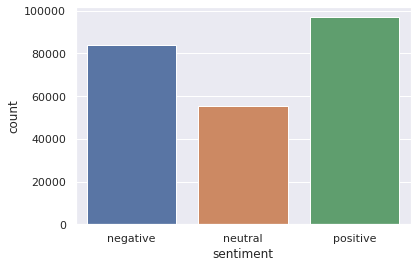

In [ ]:
import seaborn as sb
sb.set_theme(style="darkgrid")

ax = sb.countplot(x="sentiment", data=comments)